In [4]:
import numpy as np
import pandas as pd
from gensim.models import LdaMulticore
from helper_data import *
from helper_preprocess import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data

In [5]:
# Load data
walks_folder = 'data/P5'
walk_path = 'all_p3'
#data = load_all_walks_comments(walks_folder, True)
data = load_all_walks_tags(walks_folder, True)

In [6]:
data.head(10)

walk                 theme_id                  theme  \
0  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
0  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
0  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
0  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
0  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
0  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
0  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
0  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
0  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
0  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   

   video_id_in_run                                   video_link  \
0                0  https://www.youtube.com/watch?v=6TXZ4RhfpR0   
0                1  https://www.youtube.com/watch?v=w1eENwQOp_c   
0                2  https://www.youtube.com/watch?v=dv9XJ4zkQkI   
0                3  https://www.youtube.com/watch?v=DGP19_jE_pg   
0                4  https://www.youtube.com/watch?v=AmSyMYjgNy0   
0                5  https://www.youtube.com/watch?v=S1P1rmocrbM   
0                6  https://www.youtube.com/watch?v=govtar_ywqU   
0                7  https://www.youtube.com/watch?v=gEenG94aeBI   
0                8  https://www.youtube.com/watch?v=5wXhGuEnSDw   
0                9  https://www.youtube.com/watch?v=eaIuZzdIYlE   

                                               title  \
0  156 civilian evacuees from Mariupol have reach...   
0  Why Russia's military operations have fallen s...   
0  How The Russian Military Fell Short In Ukraine...   
0  After Moskva, Bayraktar Drones Strike Russian ...   
0  Was Putin’s Top General Valery Gerasimov, Woun...   
0  Putin’s Cancer Surgery Fact Or Fiction? Will E...   
0  10 Russian Drones Downed In 24 Hours l Lavrov ...   
0  Russia’s ‘Dead Hand’ l Why West Fears Putin’s ...   
0  Putin’s Nuke-Proof ‘Doomsday’ Plane Seen Flyin...   
0  Putin’s Missiles Kill 21 In Donetsk l Russia D...   

                                         description  channel_link  \
0  We finally have the result, the first result o...  UATV English   
0  When Russia launched its invasion of Ukraine, ...      CBS News   
0  Western analysts say the Russian military is f...  Insider News   
0  A Russian strike has hit a strategically impor...          CRUX   
0  Media reports suggest that chief of the Genera...          CRUX   
0  From flying jets to practicing martial arts, R...          CRUX   
0  Russian Foreign Minister Sergei Lavrov has lik...          CRUX   
0  The war in Ukraine has led to larger concerns ...          CRUX   
0  Vladimir Putin’s ‘Doomsday’ plane has reported...          CRUX   
0  Russia fired a barrage of missiles on several ...          CRUX   

                                       channel_title  \
0  https://www.youtube.com/channel/UCOmfcmDrWs7iJ...   
0  https://www.youtube.com/channel/UC8p1vwvWtl6T7...   
0  https://www.youtube.com/channel/UCHjm6wybRbldh...   
0  https://www.youtube.com/channel/UC3prwMn9aU2z5...   
0  https://www.youtube.com/channel/UC3prwMn9aU2z5...   
0  https://www.youtube.com/channel/UC3prwMn9aU2z5...   
0  https://www.youtube.com/channel/UC3prwMn9aU2z5...   
0  https://www.youtube.com/channel/UC3prwMn9aU2z5...   
0  https://www.youtube.com/channel/UC3prwMn9aU2z5...   
0  https://www.youtube.com/channel/UC3prwMn9aU2z5...   

                                            keywords nb_like   nb_views  \
0                                               News     478      1,962   
0                           CBS News  live streaming  16,377  1,145,667   
0                            News  Decoded  Politics  23,457  2,513,111   
0                                     War on Ukraine   2,997    312,100   
0   Gen. Valery Gerasimov health  Gen. Valery Ger...   4,185    3

In [10]:
data['keywords'].isna().sum()

214

In [12]:
data.shape

(2377, 15)

In [13]:
data.loc[data['video_duration'] == 'None'].shape

(0, 15)

In [14]:
# Drop the videos where nan occurs
data = data.dropna(subset='keywords')
tags = data['keywords'].tolist()
walks_id = data['walk'].tolist()

In [15]:
len(tags)

2377

In [16]:
# To remove afterwards
data = data[data['video_duration'] != 'None']

## Preprocessing

In [17]:
# Preprocess the data
tags_prep = [preprocess(t, tag=True) for t in tags]

In [18]:
# Filter out words that appear in more than 30% of the videos and words that
# appear less than 3 times
min_words = 3
max_freq = 0.3

dictionary, corpus = create_corpus(tags_prep, min_words, max_freq)

In [19]:
len(corpus)

2377

## LDA

In [20]:
# LDA parameters
workers = 3
passes = 1000
random_state = 123
num_topics = 12
alpha = 0.05 # < 1 gives sparse topics distributions
eta = 0.05 # < 1 gives sparse words distribution inside each topic

lda_model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=workers, passes=passes, random_state=random_state, alpha=alpha, eta=eta)

In [21]:
lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=10)

[(0,
  [('ted', 0.11643601),
   ('tedx', 0.047851223),
   ('talk', 0.03672978),
   ('english', 0.030406404),
   ('day', 0.029902441),
   ('united', 0.028308516),
   ('state', 0.027423758),
   ('theory', 0.019621622),
   ('country', 0.017291507),
   ('field', 0.015363647)]),
 (1,
  [('amber', 0.046065703),
   ('heard', 0.045614306),
   ('johnny', 0.03794041),
   ('depp', 0.0361348),
   ('show', 0.033203613),
   ('daily', 0.031566318),
   ('korea', 0.02934304),
   ('north', 0.028009268),
   ('falklands', 0.024398027),
   ('bahamas', 0.02155412)]),
 (2,
  [('new', 0.049448125),
   ('theory', 0.023667594),
   ('show', 0.022543296),
   ('university', 0.01987706),
   ('physic', 0.019231977),
   ('york', 0.018209558),
   ('school', 0.017415164),
   ('white', 0.017108709),
   ('house', 0.015886633),
   ('interview', 0.014415889)]),
 (3,
  [('morning', 0.032950297),
   ('biathlon', 0.024914123),
   ('britain', 0.022266237),
   ('audition', 0.020521365),
   ('show', 0.020110605),
   ('hannity', 

Tests made :
passes=10 for below
- alpha=0.5, eta=1, num_topics=10 :
    - Individual topics easily interpretable, but some are a bit mixed -> decrease alpha and maybe eta too, to get more polarized topics in each video and more specific vocabulary in each topic
    - Multiple topics about the same subject : especially music -> reduce number of topics
- alpha=0.2, eta=1, num_topics=10 :
    - More polarized topics as wanted
    - Still some mixed topics
    - Still multiple topics about the same subjects (especially music again)
- alpha=0.2, eta=1, num_topics=7 :
    - Fewer similar topics, but kind of more mixed words in each topic
- alpha=0.2, eta=0.8, num_topics=7 :
    - Still approx. 2 topics on music -> reduce num_topics
- alpha=0.2, eta=0.8, num_topics=6 :
    - More or less distinct topics
    - First 4 are easily interpretable but last 2 are more mixed (music-minecraft)
- alpha=0.2, eta=0.8, num_topics=5 :
    - Even more mixed up topics -> need more than 5 topics to fit well


passes=50 for below (training time is still very short)
- alpha=0.1, eta=0.7, num_topics=7 :
    - Still a bit mixed up topics in the last 2 -> might actually need to increase num_topics but set sharper alpha and eta
- alpha=0.1, eta=0.1, num_topics=8 :
    - Again the first few topics are very good but the last ones are more mixed up

Observation : might want to remove the word "official", appears often in the topics (e.g. for music, etc) but not really informative about the subject

passes=100 for below (training time is still very short)
- alpha=0.1, eta=0.1, num_topics=8 :
    - Similar to passes=50
- alpha=50/num_topics (typical value used in practice), eta=0.1, num_topics=8 :
    - Quite good topics but somewhat mixed -> try to lower the 50
- alpha=25/num_topics, eta=0.1, num_topics=8 :
    - Quite good topics
- alpha=25/num_topics, eta=0.1, num_topics=7 :
    - Quite good topics but a bit more mixed -> keep num_topics=8
- alpha=1, eta=0.1, num_topics=8 :
    - Quite good topics but got two music topics
- alpha=25/num_topics, eta=0.01, num_topics=8 :
    - Topics very similar to previous setup
    - Again 2 topics on music
- alpha=10/num_topics, eta=0.01, num_topics=8 :
    - Again very similar to previous setup
    - And again 2 topics on music
- alpha=0.99, eta=0.1, num_topics=15 :
    - Not so bad : many similar topics but more interpretable (less mixed)


In the end -> have to tune with final data

In [22]:
# Interpret the topics
topics_name = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
topic_id2name = {i: topics_name[i] for i in range(num_topics)}
topic_name2id = {v: k for k, v in topic_id2name.items()}

## Clustering the videos

In [23]:
# Build the "embeddings" for each document using its topics distribution
embeddings = np.zeros((len(corpus), num_topics))
for i, doc_bow in enumerate(corpus):
    topics_distr = lda_model.get_document_topics(doc_bow)
    embedding = [0.0] * num_topics

    for id, p in topics_distr:
        embedding[id] = p

    embeddings[i, :] = embedding

In [24]:
embeddings.shape

(2377, 12)

Eventually do a silouhette score to test what is the best number of topics.

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
corpus_emb=pca.fit_transform(embeddings)

In [ ]:
from sklearn.manifold import TSNE

# Init pca is more stable,
#tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=random_state)
#corpus_emb = tsne.fit_transform(embeddings)

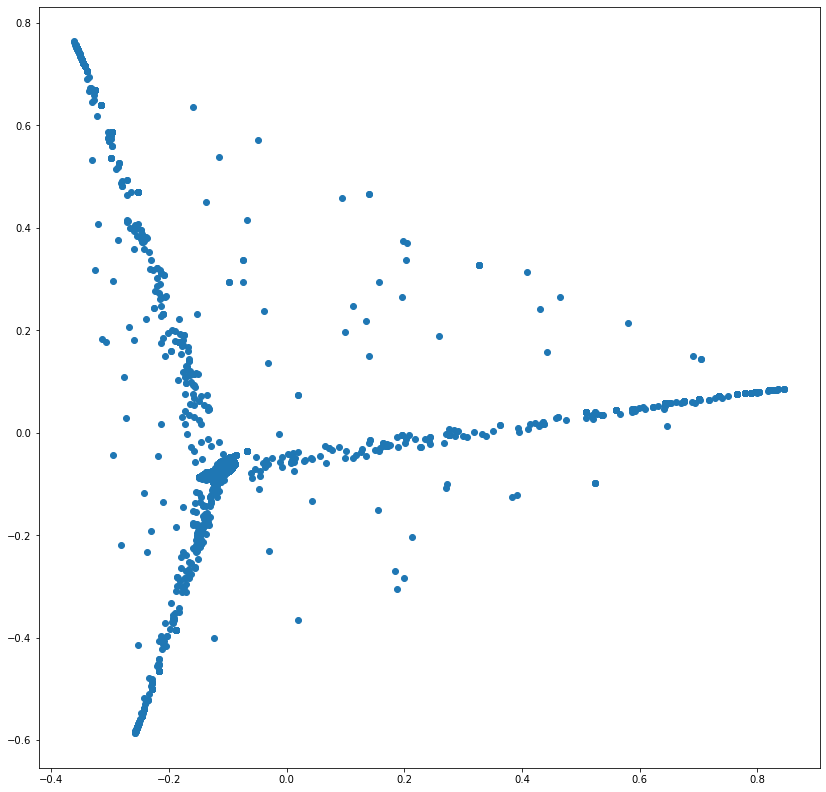

In [26]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,14)

plt.scatter(corpus_emb[:, 0], corpus_emb[:, 1])
plt.show()

In [27]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

from matplotlib.colors import rgb2hex
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

Loading BokehJS ...

In [28]:
xs, ys = corpus_emb[:, 0], corpus_emb[:, 1]
best_topic_ids = [np.argmax(row) for row in embeddings.tolist()]

# We will need to separate runs, here we have all runs of P3
colors = [val2rgb(i) for i in range(len(xs))]

In [29]:
# Use pandas and plotly instead
df = pd.DataFrame({'x': corpus_emb[:, 0], 'y': corpus_emb[:, 1], 'best_topic_id': best_topic_ids, 'walk_id': [str(i) for i in walks_id], 'color': colors})

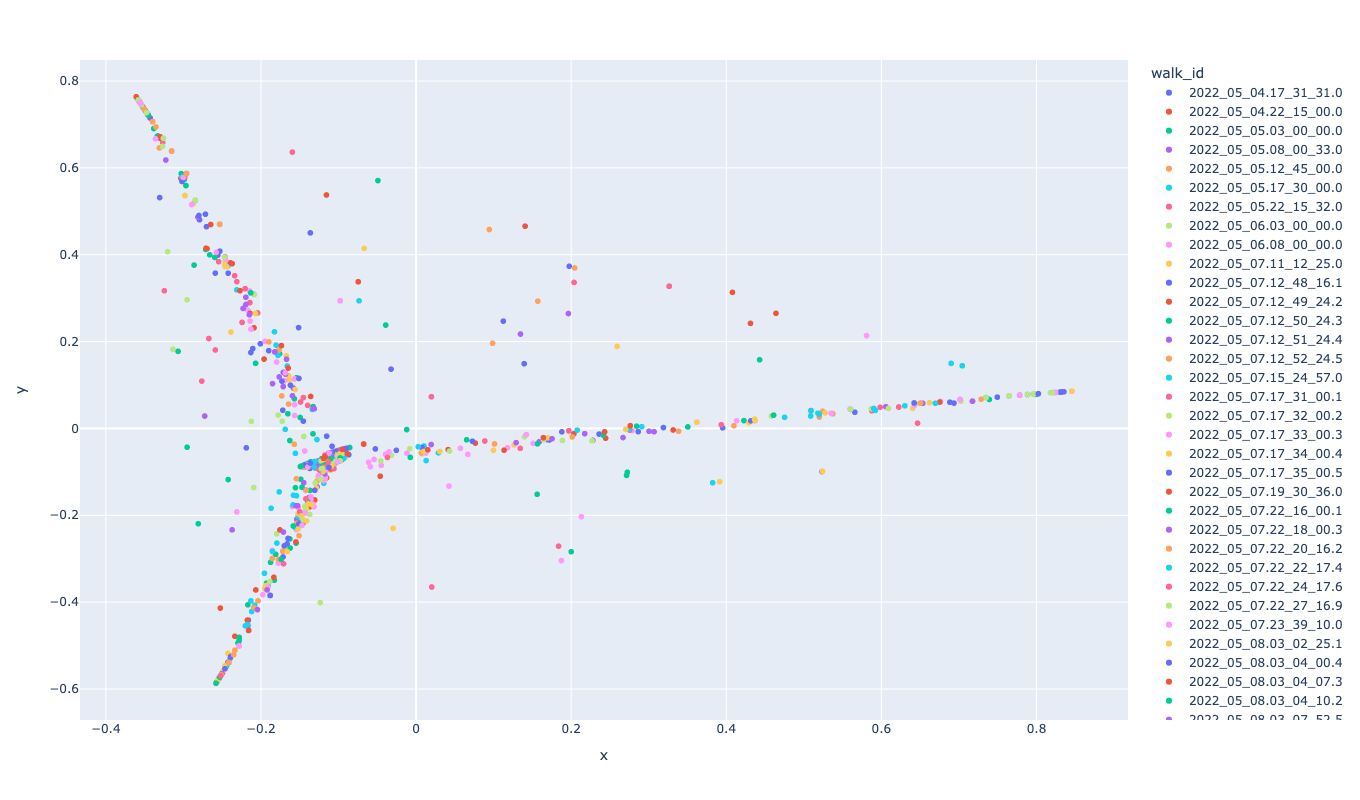

In [30]:
import plotly.express as px

fig = px.scatter(df, x='x', y='y', color='walk_id', hover_data=['best_topic_id'], width=800, height=800)
fig.show()

Output df with all original columns, columns for the topics distribution, one column for the most important topic of the video, one column for the most attributed topic in the run of this video.

In [31]:
embeddings.shape

(2377, 12)

In [32]:
df_embeddings = pd.DataFrame(embeddings, columns=[f'topic_id_{i}' for i in range(embeddings.shape[1])])
df_embeddings['video_best_topic_id'] = df_embeddings.apply(lambda row: np.argmax(row), axis=1)
df_embeddings['video_best_topic'] = df_embeddings['video_best_topic_id'].apply(lambda id: topic_id2name[id])
df_output = pd.concat([data.reset_index(drop=True), df_embeddings], axis=1)

In [33]:
# Only keep the first topic if there are multiple modes for a walk
df_walk_best_topic = df_output[['walk', 'video_best_topic_id']].groupby('walk').agg(lambda  x: pd.Series.mode(x)[0]).rename(columns={'video_best_topic_id': 'walk_best_topic_id'})
df_walk_best_topic['walk_best_topic'] = df_walk_best_topic['walk_best_topic_id'].apply(lambda id: topic_id2name[id])
df_output = df_output.join(df_walk_best_topic, on='walk', how='left')

In [34]:
df_output.head()

walk                 theme_id                  theme  \
0  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
1  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
2  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
3  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   
4  2022_05_04.17_31_31.0  0:Mariupol Zaporizhzhia  Mariupol Zaporizhzhia   

   video_id_in_run                                   video_link  \
0                0  https://www.youtube.com/watch?v=6TXZ4RhfpR0   
1                1  https://www.youtube.com/watch?v=w1eENwQOp_c   
2                2  https://www.youtube.com/watch?v=dv9XJ4zkQkI   
3                3  https://www.youtube.com/watch?v=DGP19_jE_pg   
4                4  https://www.youtube.com/watch?v=AmSyMYjgNy0   

                                               title  \
0  156 civilian evacuees from Mariupol have reach...   
1  Why Russia's military operations have fallen s...   
2  How The Russian Military Fell Short In Ukraine...   
3  After Moskva, Bayraktar Drones Strike Russian ...   
4  Was Putin’s Top General Valery Gerasimov, Woun...   

                                         description  channel_link  \
0  We finally have the result, the first result o...  UATV English   
1  When Russia launched its invasion of Ukraine, ...      CBS News   
2  Western analysts say the Russian military is f...  Insider News   
3  A Russian strike has hit a strategically impor...          CRUX   
4  Media reports suggest that chief of the Genera...          CRUX   

                                       channel_title  \
0  https://www.youtube.com/channel/UCOmfcmDrWs7iJ...   
1  https://www.youtube.com/channel/UC8p1vwvWtl6T7...   
2  https://www.youtube.com/channel/UCHjm6wybRbldh...   
3  https://www.youtube.com/channel/UC3prwMn9aU2z5...   
4  https://www.youtube.com/channel/UC3prwMn9aU2z5...   

                                            keywords  ... topic_id_6  \
0                                               News  ...   0.031250   
1                           CBS News  live streaming  ...   0.010870   
2                            News  Decoded  Politics  ...   0.019231   
3                                     War on Ukraine  ...   0.019231   
4   Gen. Valery Gerasimov health  Gen. Valery Ger...  ...   0.000000   

  topic_id_7 topic_id_8  topic_id_9  topic_id_10  topic_id_11  \
0   0.031250   0.031250    0.031250     0.031250     0.031250   
1   0.010870   0.448146    0.010870     0.010870     0.010870   
2   0.019231   0.019231    0.019231     0.019231     0.019231   
3   0.019231   0.019231    0.019231     0.403847     0.403844   
4   0.000000   0.000000    0.056764     0.192415     0.000000   

   video_best_topic_id  video_best_topic  walk_best_topic_id  walk_best_topic  
0                    5                 f                   1                b  
1                    8                 i                   1                b  
2                    5                 f                   1                b  
3                   10                 k                   1                b  
4                    5                 f                   1                b  

[5 rows x 31 columns]

# Visualizations + Basic statistics for website

In [35]:
df_output['x'] = corpus_emb[:, 0]
df_output['y'] = corpus_emb[:, 1]

In [36]:
all_topics = df_output['video_best_topic'].unique().tolist()

In [37]:
from matplotlib.colors import rgb2hex
cmap = plt.get_cmap('magma')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

def str2color(txt):
    return rgb2hex(cmap(topic_name2id[txt])[:3])

## Basic statistics

### Histogramme nombre de vidéos par topic

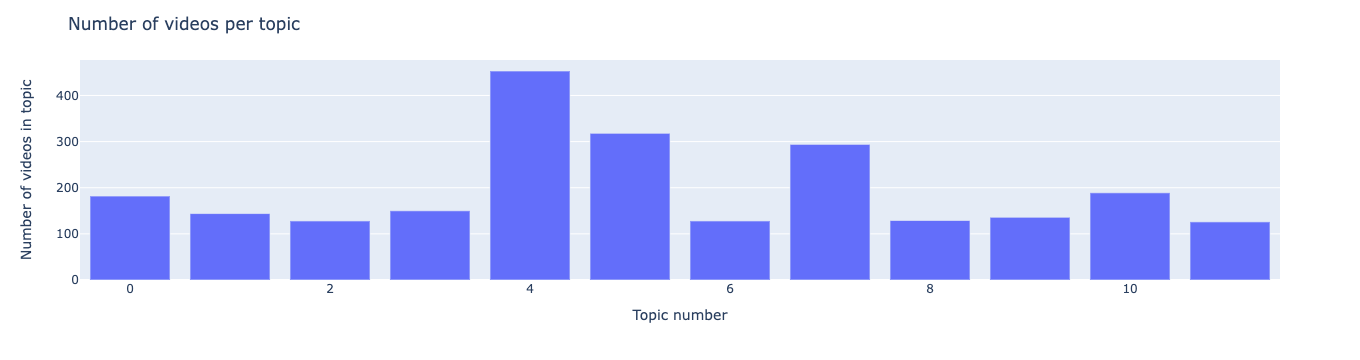

In [38]:
# Compute the histogram data
data_df = df_output.loc[:,['keywords', 'video_best_topic_id']]\
                    .groupby('video_best_topic_id')\ # Group videos by their videos best_topic_id
                    .count()\ # Perform the count needed for the histogram
                    .reset_index()\
                    .rename(columns={"video_best_topic_id":"Topic", "keywords":"Count"}) # rename columns to more meaningful title
# Create plot
fig = px.bar(data_df, x='Topic',y="Count")
fig.update_layout(
    title="Number of videos per topic",
    xaxis_title="Topic number",
    yaxis_title="Number of videos in topic")
fig.show()

In [39]:
# Give each video a unique id for the video position in the run
df_output['video_id_in_run'] = df_output.groupby(['walk']).cumcount()

In [50]:
# Compute histogram data 
data_df = df_output.groupby(['video_id_in_run', 'video_best_topic_id'])\ # Group videos by their best topic and video position in run
                    .count()\ # count for histogram 
                    .reset_index()\
                    .loc[:,["video_id_in_run", "video_best_topic_id","title"]]\ # Keep only needed columns
                    .rename(columns={"title":"count", "video_best_topic_id":"Video topic", "video_id_in_run":"Video position in run"}) # Rename columns to have more meaningful name

# Set empty (video_id_in_run, video_best_topic_id) pairs to 0 to avoid issue when plotting
for i in range(data_df["Video position in run"].max()+1):
    for j in range(12):
        cur = data_df[data_df["Video position in run"]==i]
        cur = cur[cur["Video topic"]==j]
        if len(cur)==0:
            # add a row with 0 count if the dataframe doesn't contain anything for the (video_id_in_run, video_best_topic_id) pair
            data_df=pd.concat([data_df, pd.DataFrame.from_dict({"Video position in run":[i], "Video topic":[j], "count":[0]})])

Video position in run  Video topic  count
227                     19            1      1
228                     19            2      2
229                     19            3      1
230                     19            4      4
231                     19            5      1
232                     19            6      1
233                     19            7      3
234                     19            8      3
235                     19            9      1
236                     19           10      1
237                     19           11      1
0                       19            0      0

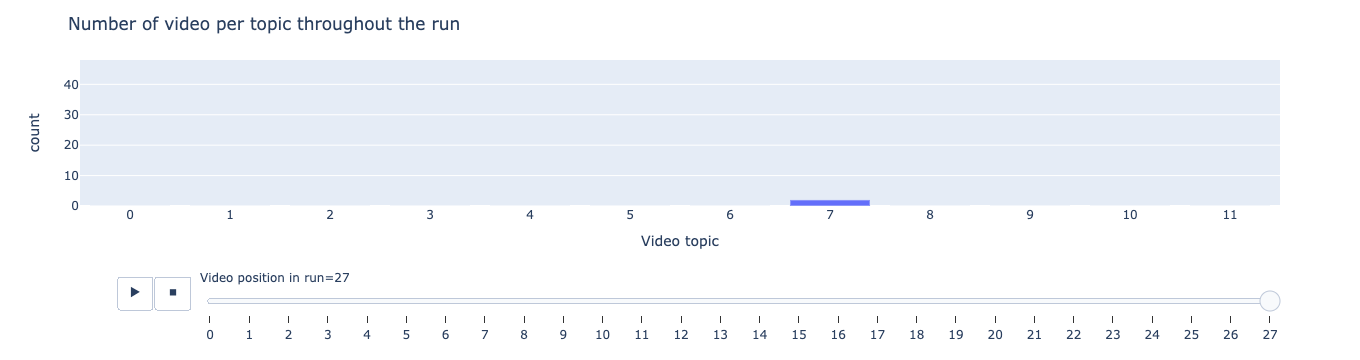

In [51]:
import plotly.express as px
# Get the maximal value
max_value = data_df["count"].max()
# Plot animated histogram
fig = px.bar(data_df, x="Numéro de topic", y="Nombre de vidéo dans le topic", animation_frame="Position de la vidéo dans la run",  range_y=[0, max_value], range_x=[-0.5, 11.5])
# Set the time between frame to 1.1 sec
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1100
fig.update_xaxes(tick0=0)
fig.update_xaxes(dtick=1)
fig.update_layout(
    title="Nombre de vidéo par topic durant une run"
)
fig.show()

### Histogramme nombre de runs par topic

In [52]:
df_output['walk_best_topic_id'].unique()

array([ 1,  5,  4,  9,  0, 10,  7,  3,  8,  2,  6, 11])

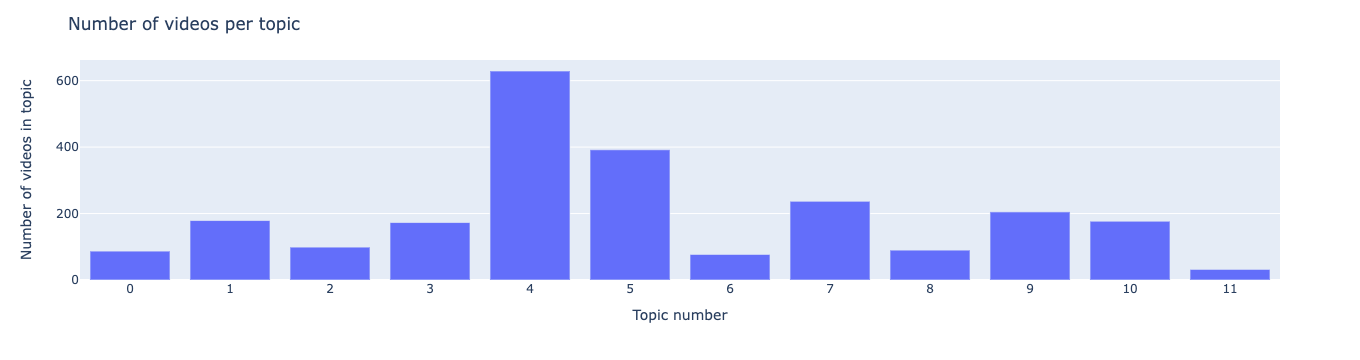

In [53]:

data_df = df_output.loc[:,['keywords', 'walk_best_topic_id']]\ # Group videos by their walk best topic and video position in run
                    .groupby('walk_best_topic_id')\
                    .count()\ # count for histogram 
                    .reset_index()\
                    .rename(columns={"walk_best_topic_id":"Topic", "keywords":"Count"})# Rename columns to have more meaningful name

# Plot the histogram 
fig = px.bar(data_df, x='Topic',y="Count")
fig.update_layout(
    title="Nombre de runs par topic",
    xaxis_title="Numéro de topic",
    yaxis_title="Nombre de runs classifié dans le topic ",
xaxis=dict(
    tickmode = 'array',
      tickvals=np.arange(0, embeddings.shape[1]).astype(int),
))
fig.show()

### Navigation pour les runs partant des mêmes mots clés

In [199]:
def get_xs(df, i):
    """
    Get the next 3 X position in the dataframe
    :param df: the dataframe
    :param i: starting position
    :return: a list with the next 3 x position in the dataframe
    """
    return [df[df["video_id_in_run"]==i]["x"][i],df[df["video_id_in_run"]==i+1]["x"][i+1],df[df["video_id_in_run"]==i+2]["x"][i+2]]

def get_ys(df, i):
    """
    Get the next 3 y position in the dataframe
    :param df: the dataframe
    :param i: starting position
    :return: a list with the next 3 y position in the dataframe
    """
    return [df[df["video_id_in_run"]==i]["y"][i],df[df["video_id_in_run"]==i+1]["y"][i+1],df[df["video_id_in_run"]==i+2]["y"][i+2]]

517         0
641      6369
762    247314
Name: nb_views, dtype: int64


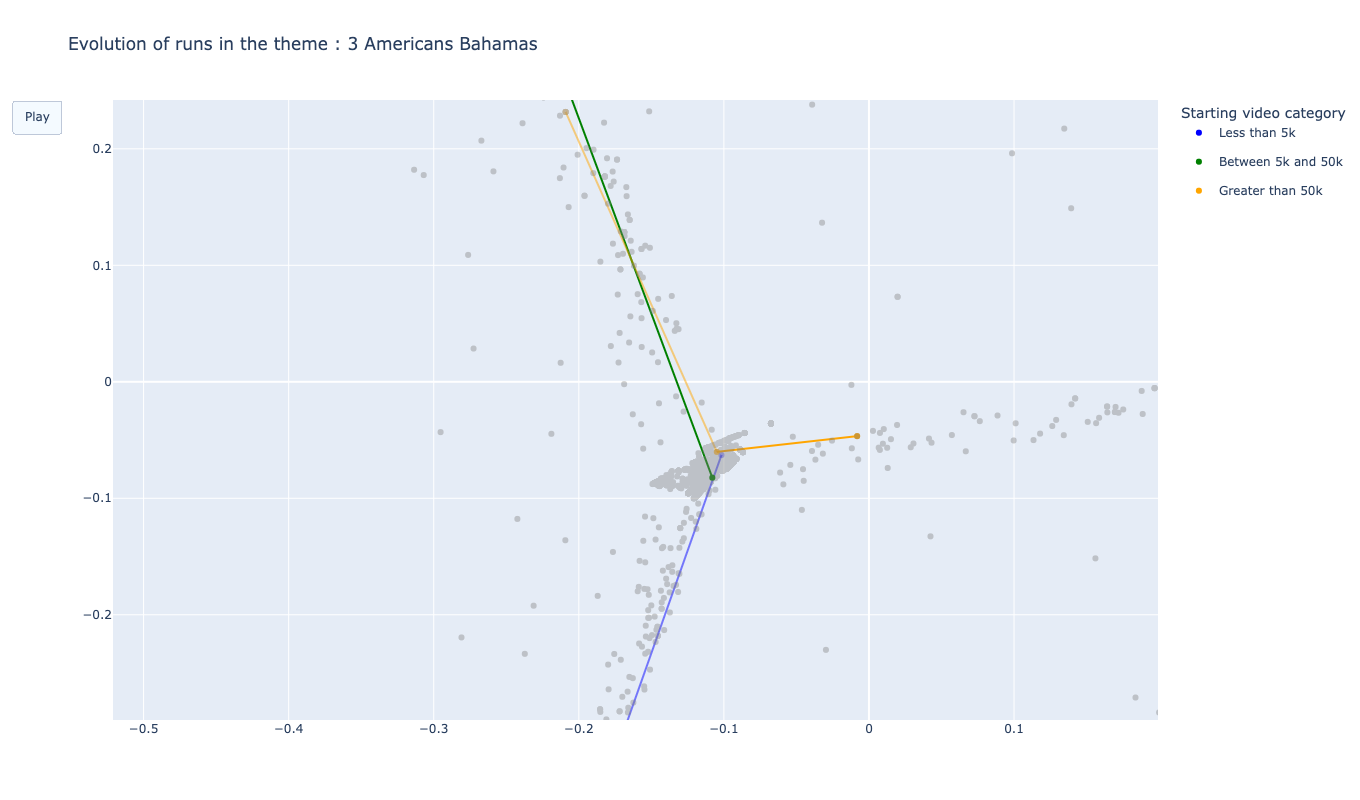

In [224]:
import plotly.graph_objects as go
df_output.nb_views = df_output.nb_views.apply(lambda x: int(x.replace(",","")) if x != "None" else 0)
for idx, group in df_output.groupby('theme_id'):
    # select only the data for the current runs
    runs_of_interest = df_output[df_output['theme_id']==idx].sort_values("walk")
    
    # Get mappins for walk_id to its view category
    walk_id = runs_of_interest[runs_of_interest['video_id_in_run']==0].sort_values("nb_views",ascending=True).walk.reset_index(drop=True)
    names = {walk_id[0]:"Moins de 5'000 vues", walk_id[1]:"Entre 5'000 et 50'000", walk_id[2]:"Plus que 50'000 vues"}
    
    # Get the minimal number of videos in any of the walk for the current subject
    max_length = runs_of_interest.groupby('walk').max('video_id_in_run')['video_id_in_run'].min()
    
    # Start with empty data
    data = []              
    frames = []
    
    # Define color for the plot
    colors = ["blue", "green", "orange"]
    
    # Create animation for the 
    for i in range(max_length-2):
        # List that will store the current frame data
        cur_frame = []
        
        # Counter to know in which 
        cpt=0
        for j, group2 in runs_of_interest.groupby('walk'):
            #
            cur_data = group2.sort_values("video_id_in_run").reset_index()
            # Collect hover data 
            
            
            # Get the current considered point and the two nexts
            xs = get_xs(cur_data,i)
            ys = get_ys(cur_data,i)
            
            # Iterate over every run in the subject
            for k in range(len(names)):
                infos = []
                cur_data[cur_data.video_id_in_run==k].apply(lambda x: infos.append([names[x['walk']],x['title'], x['nb_views'],x['video_duration']]),axis=1)
                # plot the current 3 considered data points for the run 
                cur_frame.append(go.Scatter(
                                    x=[xs[k]],
                                    y=[ys[k]],
                                    marker = {'color' : colors[cpt], "opacity":(k+1)*1/3}, # set the opacity to 1/3 for the oldest points to 1 for the latest
                                    mode='markers',
                                    customdata=infos,
                                    hoverinfo="none",# Disable run number information
                                    hovertemplate='Run:%{customdata[0]}<br>Titre:%{customdata[1]}<br>Nombre de vues: %{customdata[2]}<br>Durée de la vidéo (sec): %{customdata[3]}<br>x:%{x:.3f}<br>y:%{y:.3f}',#Display custom information on hover 
                                    name=names[j],# Add name for the legend panel
                                    showlegend=(k==(len(names)-1)), # Show the legend only for the latest point
                                    legendgroup=colors[cpt]))
            
            # Draw line between the poitns cosnidered 
            for k,l in [[0,1], [1,2]]:
                cur_frame.append(go.Scatter(
                                    x=[xs[k], xs[l]],
                                    y=[ys[k], ys[l]],
                                    marker = {'color' : colors[cpt]},
                                    mode='lines',
                                    opacity=l*1/2,
                                    hoverinfo="none",# Disable run number information
                                    name=names[j],# Add name for the legend panel
                                    showlegend=False,
                                    legendgroup=colors[cpt]))
            
            cpt+=1
        if i==0:
            # Set other data to grey to put the run in context
            data = cur_frame+[go.Scatter(x=df_output['x'].values,
                                    y=df_output['y'].values,
                                    mode = 'markers',
                                    opacity=0.4,
                                    marker={"color":"grey"},
                                    showlegend=False,
                                    hoverinfo="skip",
                                    name="")]
        # Append the current frame to all the frames
        frames.append(go.Frame(data=cur_frame))
    
    # Create a animated scatter plot
    fig = go.Figure(
        data=data,
        layout=go.Layout(
            xaxis=dict(range=[-1, 1]),
            yaxis=dict(range=[-1, 1]),
            title="Evolution de la run pour le thème : "+runs_of_interest.theme.unique()[0],
            updatemenus=[dict(
                type="buttons",
                buttons=[dict(label="Play",
                              method="animate",
                              args = [None, {"frame": {"duration": 800,"redraw": False},
                                                                  "fromcurrent": True, 
                                                                  "transition": {"duration": 300}}])])] # Set transition duration
        ),
        frames=frames
    )
    
    fig.update_layout(
        width=800,
        height=800,
        legend_title_text='Catégorie (en fonction des vues) de la vidéo de départ '
    )
    fig.show()
    
    break

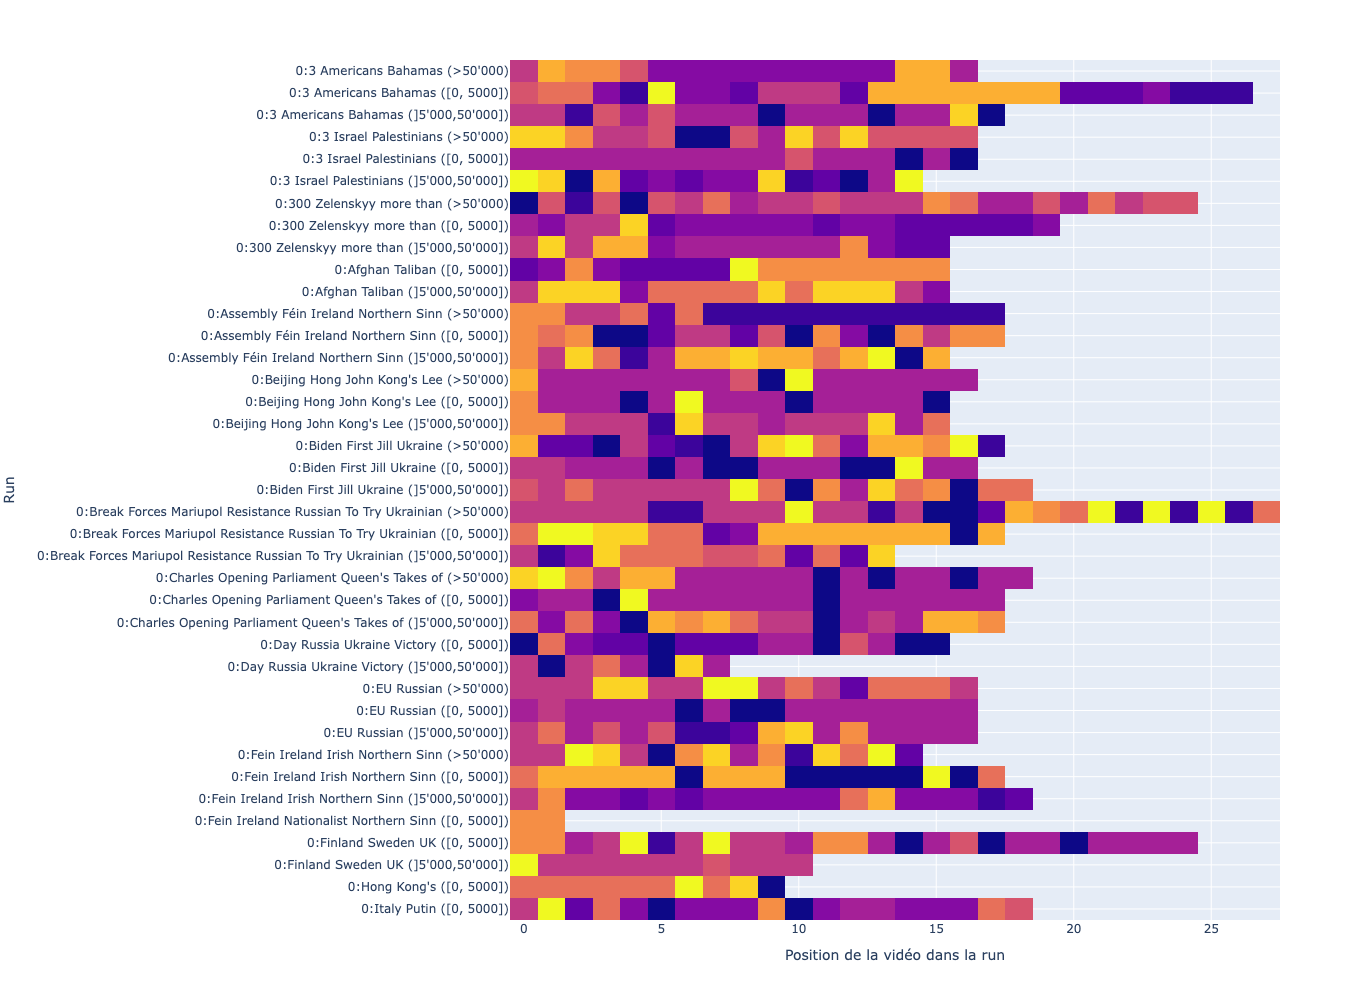

In [262]:
names = {}
label = ["[0, 5000]", "]5'000,50'000]", ">50'000"]

for idx, group in df_output.groupby("theme_id"):
    cpt=0
    for idx2, row in group[group['video_id_in_run']==0].sort_values("nb_views",ascending=True).iterrows():
        names[row['walk']] = row["theme_id"] + " (" +label[cpt]+")"
        cpt+=1

df_plot = df_output.copy()
df_plot['id'] = df_output.apply(lambda x: names[x['walk']],axis=1)
df_plot = df_plot.rename(columns={"id":"Run", "video_id_in_run":"Position de la vidéo dans la run", "video_best_topic_id": "Meilleur topic pour la vidéo"})
df_plot = df_plot.pivot(index='Run', columns='Position de la vidéo dans la run', values='Meilleur topic pour la vidéo').iloc[:39,:]
fig = px.imshow(df_plot)
fig.update_layout(
    height=1000,
    coloraxis={"showscale":False}
)
fig.show()

### Video duration through the runs

In [36]:
df_output.head()

video_link  \
0  https://www.youtube.com/watch?v=o5zCG7odLWQ   
1  https://www.youtube.com/watch?v=PAyl2XiWZyo   
2  https://www.youtube.com/watch?v=S27kw7XVvSA   
3  https://www.youtube.com/watch?v=rrbJ2Y4xHWg   
4  https://www.youtube.com/watch?v=KWhOXip6L4I   

                                               title  \
0  Moment Azov fighter ambushes Russian BMP in Ma...   
1  Drone video team turns the tables on hiding Ru...   
2  Ukrainian tank single handedly destroys massiv...   
3  Rotting dead Russian soldiers found in trenche...   
4  Ukrainian mortars destroy Russian ammo depot i...   

                                         description channel_link  \
0  Footage posted on April 8 by the Azov Battalio...      The Sun   
1  CNN's Frederik Pleitgen shows how the use of d...          CNN   
2  INCREDIBLE drone footage shows the moment a ma...      The Sun   
3  The Sun's Defence Editor Jerome Starkey finds ...      The Sun   
4  This aerial video shows a Russian ammo depot s...      The Sun   

                                       channel_title  \
0  https://www.youtube.com/channel/UCIzXayRP7-P0A...   
1  https://www.youtube.com/channel/UCupvZG-5ko_ei...   
2  https://www.youtube.com/channel/UCIzXayRP7-P0A...   
3  https://www.youtube.com/channel/UCIzXayRP7-P0A...   
4  https://www.youtube.com/channel/UCIzXayRP7-P0A...   

                                            keywords nb_like   nb_views  \
0  The Sun  Covid-19  russian soldiers ambushed i...  39,630  3,914,744   
1  latest News  CNN  CNN Tonight  Russia Ukraine ...  53,221  5,351,548   
2  The Sun  Ukrainian tank ambush destroying Russ...  71,790  8,843,301   
3  The Sun  Covid-19  found in trenches  Putin co...  38,113  4,375,937   
4  The Sun  100 civilians escaped the Azovstal  w...  18,212  1,867,919   

  nb_sub  video_duration  ...  topic_id_8  topic_id_9 topic_id_10  \
0  2.87M             102  ...    0.291359         0.0         0.0   
1  13.8M             310  ...    0.000000         0.0         0.0   
2  2.87M             117  ...    0.936046         0.0         0.0   
3  2.87M             126  ...    0.691256         0.0         0.0   
4  2.87M             140  ...    0.936046         0.0         0.0   

   topic_id_11  video_best_topic_id  video_best_topic  walk_best_topic_id  \
0          0.0                    5                 f                   8   
1          0.0                    5                 f                   8   
2          0.0                    8                 i                   8   
3          0.0                    8                 i                   8   
4          0.0                    8                 i                   8   

   walk_best_topic         x         y  
0                i -0.222723 -0.240650  
1                i -0.217254 -0.206442  
2                i -0.250351 -0.339750  
3                i -0.213555 -0.262365  
4                i -0.250351 -0.339750  

[5 rows x 31 columns]

In [37]:
df_output.groupby('walk').cumcount()

0       0
1       1
2       2
3       3
4       4
       ..
96     13
97     14
98     15
99     16
100    17
Length: 101, dtype: int64

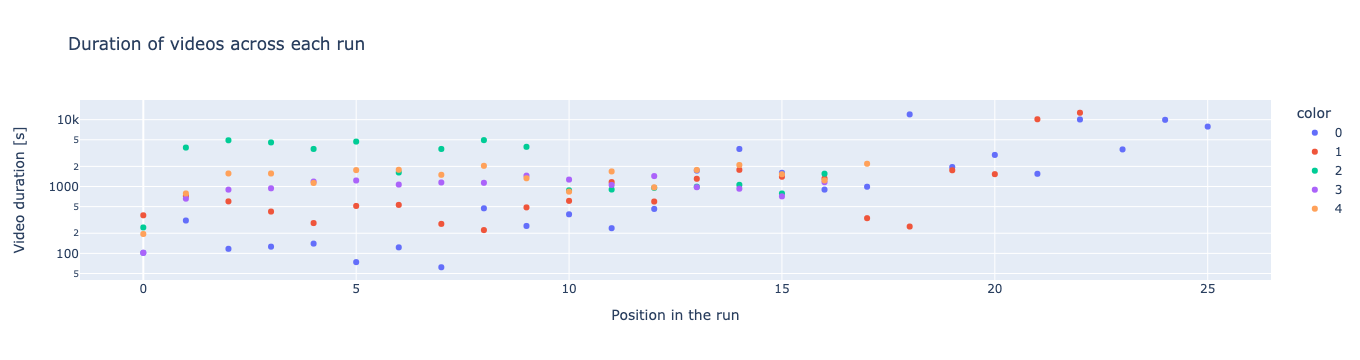

In [38]:
fig = px.scatter(df_output, x=df_output.groupby('walk').cumcount(), y='video_duration',
              color=df_output['walk'].astype(str), title='Duration of videos across each run',
                 log_y=True,
                 labels={'video_duration': 'Video duration [s]', 'x': 'Position in the run'})

fig.show()

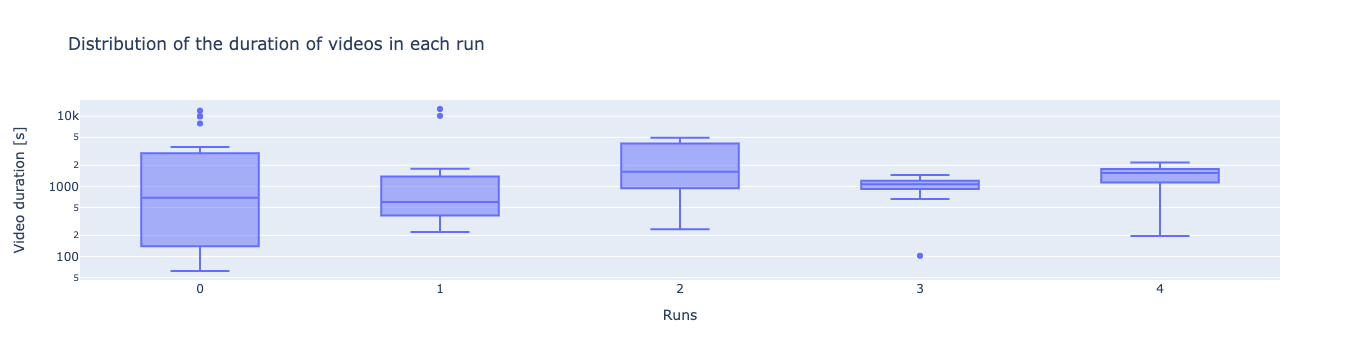

In [39]:
fig = px.box(df_output, x=df_output['walk'].astype(str), y='video_duration', log_y=True,
             title='Distribution of the duration of videos in each run',
             labels={'x': 'Runs', 'video_duration': 'Video duration [s]'})

fig.show()

### Video views through the runs

In [40]:
df_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_link           101 non-null    object 
 1   title                100 non-null    object 
 2   description          101 non-null    object 
 3   channel_link         101 non-null    object 
 4   channel_title        101 non-null    object 
 5   keywords             101 non-null    object 
 6   nb_like              101 non-null    object 
 7   nb_views             101 non-null    object 
 8   nb_sub               101 non-null    object 
 9   video_duration       101 non-null    int64  
 10  watch time           101 non-null    int64  
 11  walk                 101 non-null    int64  
 12  theme                101 non-null    object 
 13  topic_id_0           101 non-null    float64
 14  topic_id_1           101 non-null    float64
 15  topic_id_2           101 non-null    flo

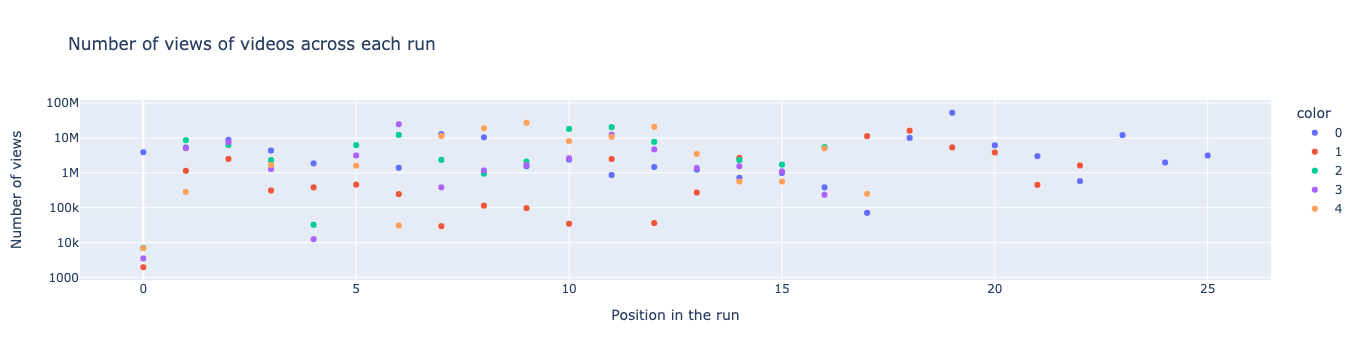

In [41]:
fig = px.scatter(df_output, x=df_output.groupby('walk').cumcount(), y='nb_views',
                 color=df_output['walk'].astype(str), title='Number of views of videos across each run',
                 log_y=True,
                 labels={'nb_views': 'Number of views', 'x': 'Position in the run'})

fig.show()

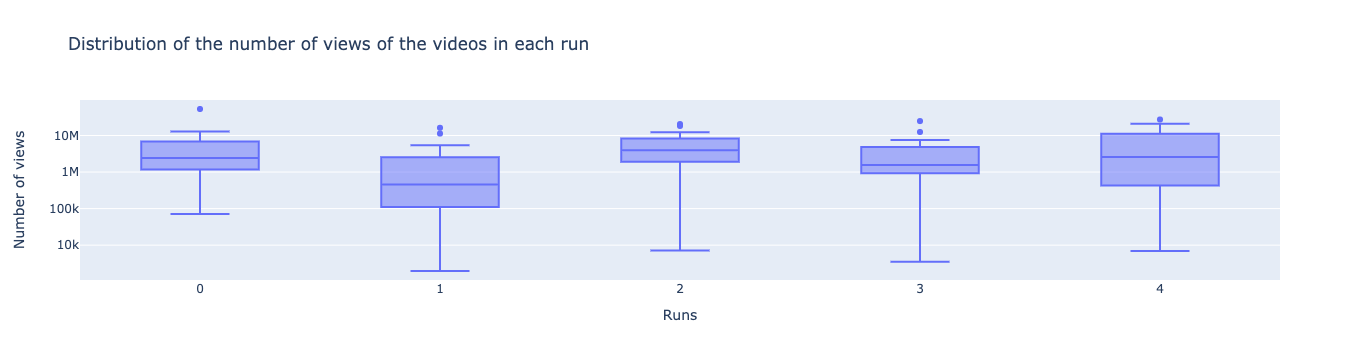

In [42]:
fig = px.box(df_output, x=df_output['walk'].astype(str), y='nb_views', log_y=True,
             title='Distribution of the number of views of the videos in each run',
             labels={'x': 'Runs', 'nb_views': 'Number of views'})

fig.show()

#### Heatmap showing the tendencies of getting from a nb_view to another

## Color runs based on the most frequent topic in this run

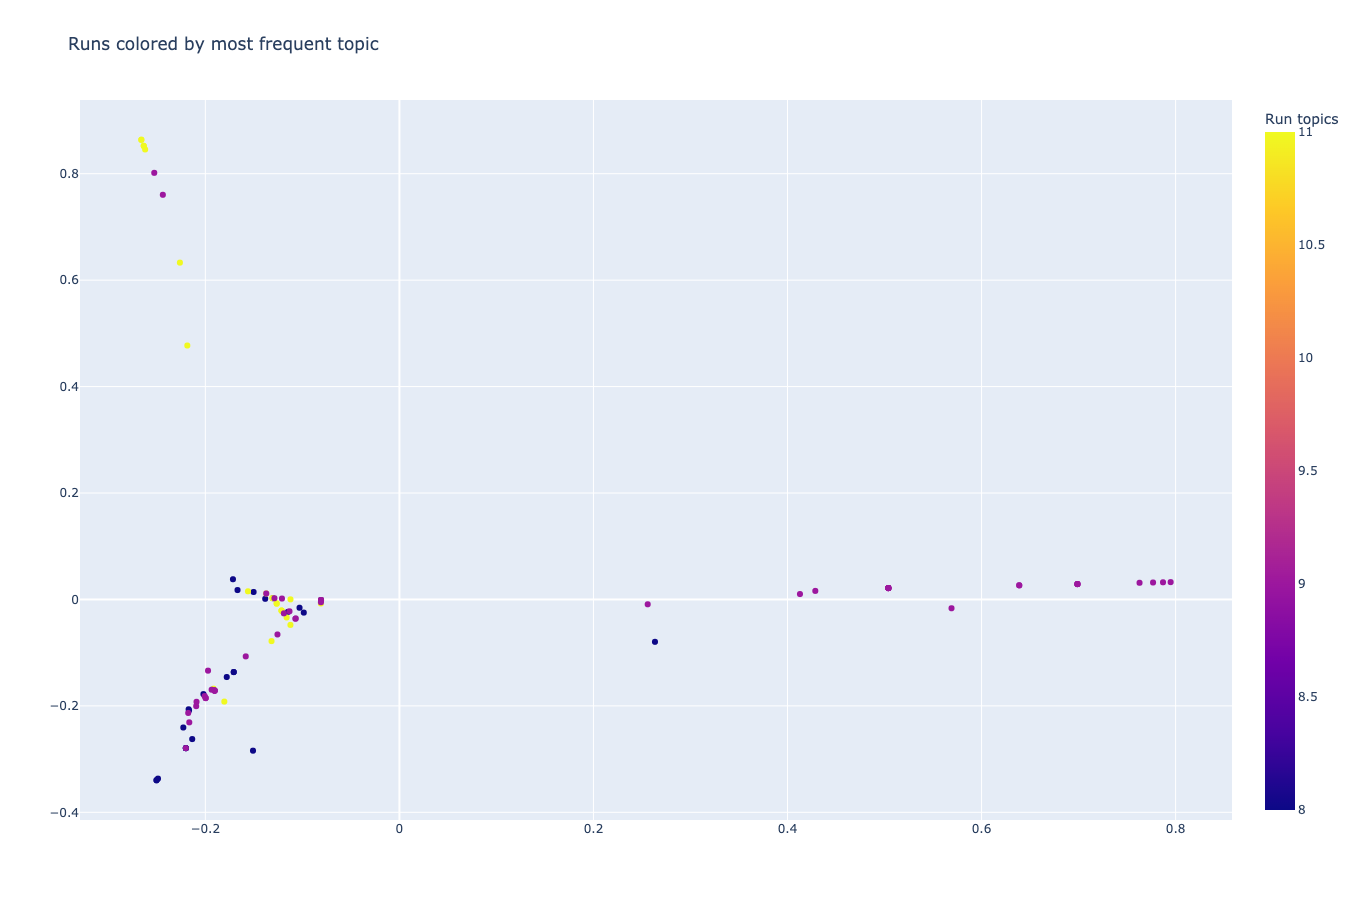

In [43]:
import plotly.graph_objects as go

fig = px.scatter(df_output, x='x', y='y', color='walk_best_topic',
                 #hover_data=['walk_best_topic'], hover_name='video_best_topic',

                 width=800, height=800,
                 title='Runs colored by most frequent topic')

customdata = df_output[['video_best_topic', 'walk_best_topic', 'walk']]

fig = go.Figure(go.Scatter(
    x=df_output['x'], y=df_output['y'],
    customdata=customdata,
    marker=dict(color=df_output['walk_best_topic_id'], colorbar=dict(title='Run topics')),
    mode='markers', name='',
    hovertemplate=
    '<br>Video topic : %{customdata[0]}</b><br>Run topic : %{customdata[1]}</b><br>Run id : %{customdata[2]}</br>'
))

fig.update_layout(
    width=1200,
    height=900,
    title='Runs colored by most frequent topic'
)
fig.show()